In [26]:
import os

import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

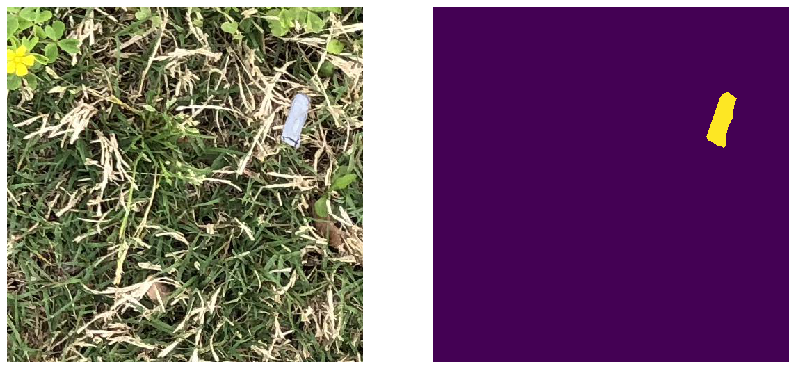

In [27]:
path = "data/train"
images = os.listdir(f"{path}/images")
annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
img_id = int(np.random.choice(images).split(".")[0])

img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg"))
mask = get_mask(img_id, annotations)
show_img_with_mask(img, mask)


In [28]:
def keras_generator( path,batch_size):

        
    while True:
        images = os.listdir(f"{path}/images")
        annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_id = int(np.random.choice(images).split(".")[0])
            img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg"))
            mask = get_mask(img_id, annotations)
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch) /255.

        yield x_batch, np.expand_dims(y_batch, -1)

In [53]:
def load_data(path,batch_size):

    annotations = json.load(open(f"{path}/coco_annotations.json", "r"))    
    while True:
        x_batch = []
        y_batch = []
        for i in range(batch_size):
            img_id = i
            img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg"))
            mask = get_mask(img_id, annotations)
            img = cv2.resize(img, (256, 256))
            
            x_batch += [img]
            y_batch += [mask]
        x_batch = np.array(x_batch) / 255.

        return x_batch, y_batch

In [85]:
def get_test( path,batch_size):

        
    while True:
        x_batch = []
        
        for i in range(batch_size):
            img_id = i
            img = np.array(Image.open(f"{path}/real_test/images/{img_id:04}.jpg"))
            img = cv2.resize(img, (256, 256))

            x_batch += [img]

        x_batch = np.array(x_batch) / 255.
        return x_batch

In [184]:
def det_mask(pred, val):
    A= np.zeros((256, 256))
    for i in range(256):
        for j in range(256):
            if (pred[i,j,0] > val):
                A[i,j]=1
    A = cv2.resize(A, (512, 512))
    
    for i in range(512):
        for j in range(512):
            if (A[i,j] != 1):
                A[i,j]=0
    return A

In [32]:
for x, y in keras_generator('data/val1',16):
    break

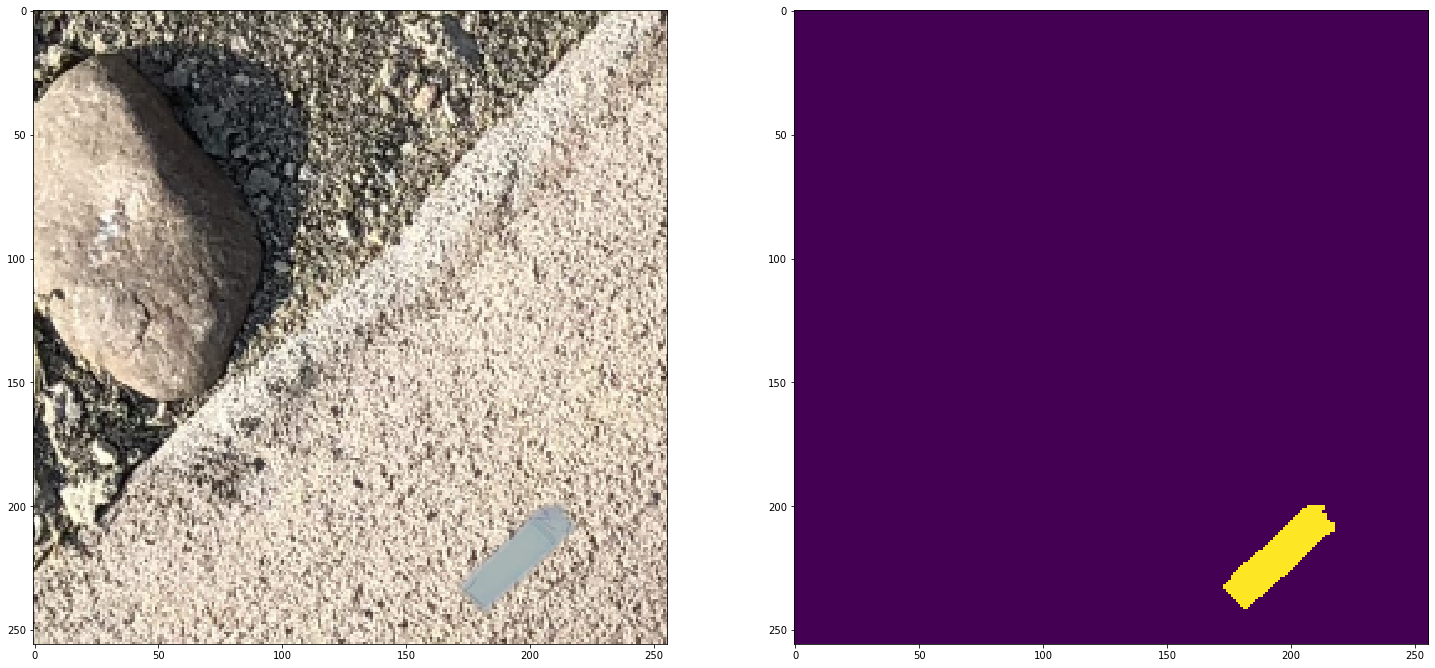

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[1])
axes[1].imshow(y[1, ..., 0] > 0.5)

In [34]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate,concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

In [35]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

In [36]:
from keras.models import Model
from keras import backend as K

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Convolution2D, ZeroPadding2D
from keras.optimizers import Adam



def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)

In [37]:
inputs = Input((256, 256, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([UpSampling2D(size=(2, 2), interpolation='bilinear')(conv5), conv4])
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([UpSampling2D(size=(2, 2), interpolation='bilinear')(conv6), conv3])
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([UpSampling2D(size=(2, 2), interpolation='bilinear')(conv7), conv2])
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([UpSampling2D(size=(2, 2), interpolation='bilinear')(conv8), conv1])
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=inputs, outputs=conv10)
        



In [38]:
conv10

<tf.Tensor 'conv2d_38/Sigmoid:0' shape=(None, 256, 256, 1) dtype=float32>

In [39]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [40]:
batch_size = 16
model.fit_generator(keras_generator('data/train', batch_size),
              steps_per_epoch=100,
              epochs=50,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator('data/val1', batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/50
100/100 [==============================] - 1600s 16s/step - loss: 0.1094 - val_loss: 0.0479
Epoch 2/50
100/100 [==============================] - 1594s 16s/step - loss: 0.0472 - val_loss: 0.0368
Epoch 3/50
100/100 [==============================] - 1586s 16s/step - loss: 0.0283 - val_loss: 0.0220
Epoch 4/50
100/100 [==============================] - 1597s 16s/step - loss: 0.0197 - val_loss: 0.0720
Epoch 5/50
100/100 [==============================] - 1603s 16s/step - loss: 0.0257 - val_loss: 0.0187
Epoch 6/50
100/100 [==============================] - 1608s 16s/step - loss: 0.0141 - val_loss: 0.0138
Epoch 7/50
100/100 [==============================] - 1593s 16s/step - loss: 0.0116 - val_loss: 0.0123
Epoch 8/50
100/100 [==============================] - 1614s 16s/step - loss: 0.0103 - val_loss: 0.0087
Epoch 9/50
100/100 [==============================] - 1597s 16s/step - loss: 0.0098 - val_loss: 0.0073
Epoch 10/50
100/100 [==============================] - 1590s 16s/step - l

KeyboardInterrupt: 

In [819]:
x1 = keras_generator1('data',10)
test = get_tast('data', 10)

In [820]:
pred = model.predict(x1)

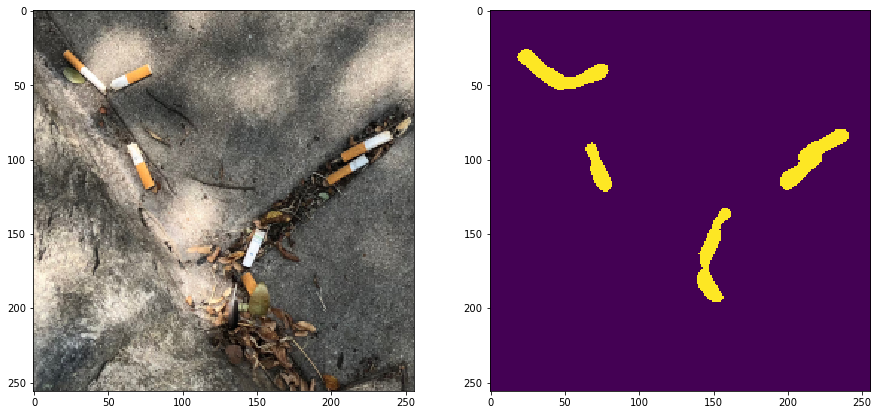

In [834]:
im_id = 9
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x1[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

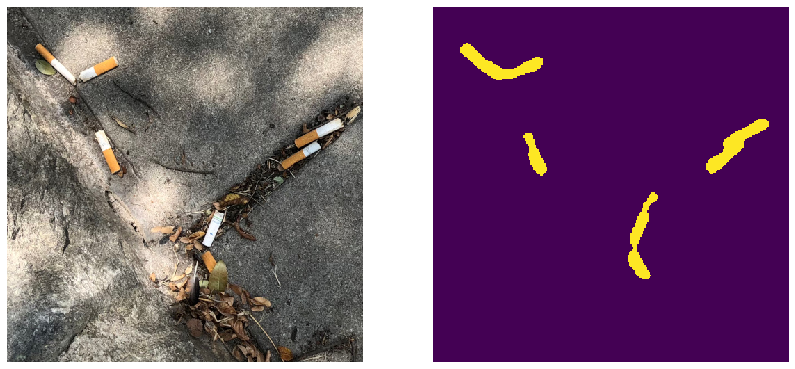

In [837]:
show_img_with_mask(test[im_id], A1)


In [841]:
len(answer)

10

In [967]:
answer[0][0,0]

0.0

In [965]:
type(answer)

list

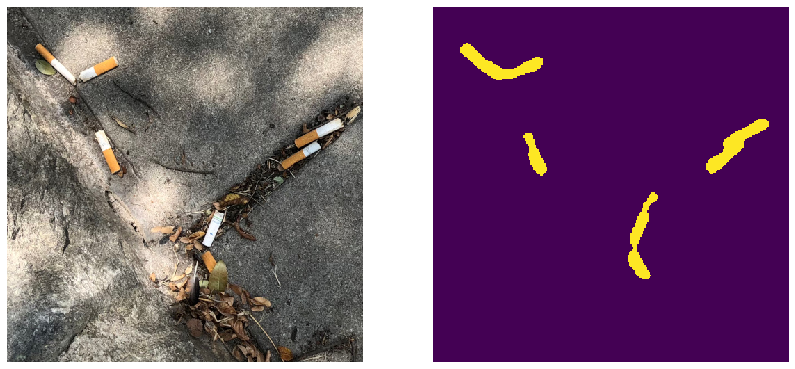

In [938]:
show_img_with_mask(test[9], answer[9])

In [1018]:
val_annotations = json.load(open(f"data/val/coco_annotations.json", "r"))
paths_to_imgs = sorted(glob("data/val/images/*"))
img_ids = [int(path.split("/")[-1].split("\\")[-1].split(".")[0]) for path in paths_to_imgs]
pred_masks = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

In [964]:
pred_masks = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]
type(pred_masks)

list

In [1017]:
pred_masks[0][0,0]

In [976]:
paths_to_imgs


['data/val/images\\00000000.png',
 'data/val/images\\00000001.png',
 'data/val/images\\00000002.png',
 'data/val/images\\00000003.png',
 'data/val/images\\00000004.png',
 'data/val/images\\00000005.png',
 'data/val/images\\00000006.png',
 'data/val/images\\00000007.png',
 'data/val/images\\00000008.png',
 'data/val/images\\00000009.png',
 'data/val/images\\00000010.png',
 'data/val/images\\00000011.png',
 'data/val/images\\00000012.png',
 'data/val/images\\00000013.png',
 'data/val/images\\00000014.png',
 'data/val/images\\00000015.png',
 'data/val/images\\00000016.png',
 'data/val/images\\00000017.png',
 'data/val/images\\00000018.png',
 'data/val/images\\00000019.png',
 'data/val/images\\00000020.png',
 'data/val/images\\00000021.png',
 'data/val/images\\00000022.png',
 'data/val/images\\00000023.png',
 'data/val/images\\00000024.png',
 'data/val/images\\00000025.png',
 'data/val/images\\00000026.png',
 'data/val/images\\00000027.png',
 'data/val/images\\00000028.png',
 'data/val/ima

In [ ]:
paths_to_imgs

In [959]:
(pred_masks[0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [977]:
paths_to_imgs = sorted(glob("data/real_test/images/*"))
img_ids = [int(path.split("/")[-1].split("\\")[-1].split(".")[0]) for path in paths_to_imgs]

_ = get_html(paths_to_imgs, answer, path_to_save="results/example")

OSError: cannot write mode F as PNG

In [978]:
Image.fromarray(answer).save(f"{path_to_save}/{img_id}_pred_mask.png")

AttributeError: 'list' object has no attribute '__array_interface__'

In [980]:
def get_html1(paths_to_imgs, pred_masks, path_to_save="results/test"):
    """Generates html file and saves it.

    Parameters
    ----------
    paths_to_imgs : list[str]
        List of paths to original images.
    pred_masks : list[np.ndarray]
        Predicted masks.
    path_to_save : str
        Path to save source images to put them in html file. Html name is the same as name of the
        last folder on `path_to_save` and is saved on upper level.

    Returns
    -------
    str
        Content of html file.

    """
    paths_to_imgs = np.array(paths_to_imgs)
    pred_masks = np.array(pred_masks)

    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    order = np.argsort(paths_to_imgs)
    paths_to_imgs = paths_to_imgs[order]
    pred_masks = pred_masks[order]

    for path_to_img, pred_mask in zip(paths_to_imgs, pred_masks):
        img_id = path_to_img.split("/")[-1].split(".")[0]
        img = np.array(Image.open(path_to_img))[:, :, :3]
        Image.fromarray(img).save(f"{path_to_save}/{img_id}_img.jpg")
        Image.fromarray(pred_mask).save(f"{path_to_save}/{img_id}_pred_mask.png")
        crop_img = img.copy()
        crop_img[pred_mask == 0] = 0
        Image.fromarray(crop_img).save(f"{path_to_save}/{img_id}_crop.png")


    return 1

In [981]:
paths_to_imgs = sorted(glob("data/real_test/images/*"))
img_ids = [int(path.split("/")[-1].split("\\")[-1].split(".")[0]) for path in paths_to_imgs]

_ = get_html1(paths_to_imgs = np.array(paths_to_imgs), answer, path_to_save="results/example")

OSError: cannot write mode F as PNG

In [985]:
paths_to_imgs = np.array(paths_to_imgs)
pred_masks = np.array(answer)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [991]:
order = np.argsort(paths_to_imgs)
paths_to_imgs = paths_to_imgs[order]
pred_masks = pred_masks[order]
pred_masks


In [1065]:
path_to_save= "results/example"
paths_to_imgs = sorted(glob("data/real_test/images/*"))
img_ids = d
pred_masks = answer

In [1022]:
path_to_save= "results/example"
val_annotations = json.load(open(f"data/val/coco_annotations.json", "r"))
paths_to_imgs = sorted(glob("data/val/images/*"))
img_ids = [int(path.split("/")[-1].split("\\")[-1].split(".")[0]) for path in paths_to_imgs]
pred_masks = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]

In [1072]:
def save_html(paths_to_imgs, pred_masks, path_to_save="results/test"):
    
    paths_to_imgs = np.array(paths_to_imgs)
    pred_masks = np.array(pred_masks)

    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    order = np.argsort(paths_to_imgs)
    paths_to_imgs = paths_to_imgs[order]
    pred_masks = pred_masks[order]

    for path_to_img, pred_mask in zip(paths_to_imgs, pred_masks):
        img_id = path_to_img.split("/")[-1].split(".")[0]
        img = np.array(Image.open(path_to_img))[:, :, :3]
        Image.fromarray(img).save(f"{path_to_save}/{img_id}_img.jpg")
        rle_mask = encode_rle(pred_mask)
        decoded_mask = decode_rle(rle_mask)
        Image.fromarray(decoded_mask).save(f"{path_to_save}/{img_id}_pred_mask.png")
        crop_img = img.copy()
        crop_img[pred_mask == 0] = 0
        Image.fromarray(crop_img).save(f"{path_to_save}/{img_id}_crop.png")


In [1073]:
paths_to_imgs = sorted(glob("data/real_test/images/*"))
save_html(paths_to_imgs, answer, "results/example")

In [1074]:
pred = pd.read_csv("data/pred_val_template.csv")
pred.head()

,img_id,rle_mask
0,0,171654 1 172158 1 172164 5 172670 3 172674 12 ...
1,1,171654 1 172158 1 172164 5 172670 3 172674 12 ...
2,2,171654 1 172158 1 172164 5 172670 3 172674 12 ...
3,3,171654 1 172158 1 172164 5 172670 3 172674 12 ...
4,4,171654 1 172158 1 172164 5 172670 3 172674 12 ...


In [1075]:
d = {"price":pd.Series([1, 2, 3], index=['v1', 'v2', 'v3']),
"count": pd.Series([10, 12, 7], index=['v1', 'v2', 'v3'])}
df1 = pd.DataFrame(d)

In [1076]:
df1.head()

,price,count
v1,1,10
v2,2,12
v3,3,7


In [21]:
data_test = keras_generator1("data/val1", 200)

In [ ]:
pred = model.predict(data_test)

In [1]:
im_id = 9
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(data_test[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

NameError: name 'plt' is not defined

**Создаем таблицу:**

In [186]:
x_val, y_val = load_data("data/val1", 200)

In [187]:
pred = model.predict(x_val)

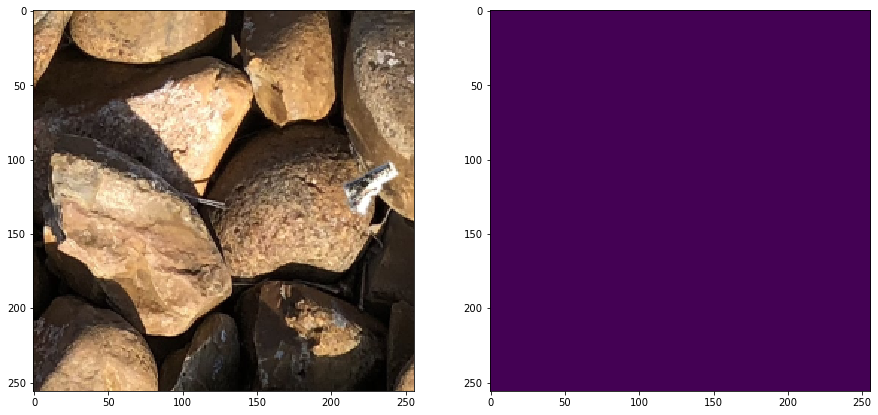

In [220]:
im_id = 196
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x_val[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

In [62]:
ans=[]
for i in range(200):
    ans.append((det_mask(pred[i], 0.5)))

In [190]:
tf = (det_mask(pred[53], 0.5))

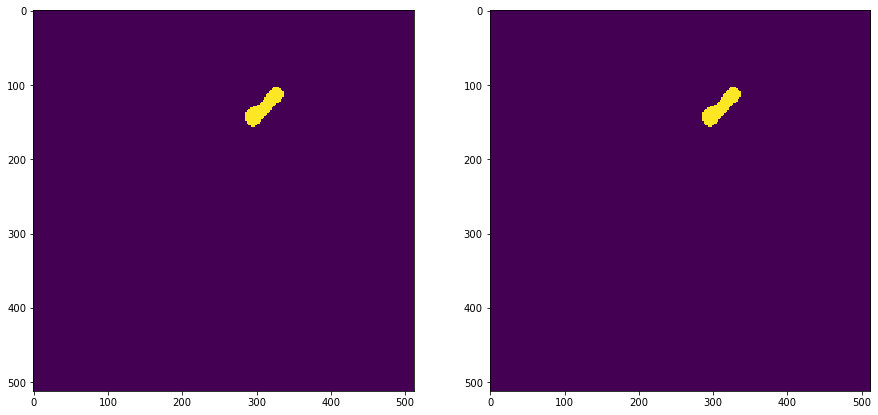

In [195]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x_val[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

In [193]:
sa=encode_rle(tf)
sa

'53060 8 53572 8 54082 12 54594 12 55104 16 55616 16 56126 20 56638 20 57148 22 57660 22 58170 24 58682 24 59194 24 59706 24 60216 24 60728 24 61240 22 61752 22 62262 24 62774 24 63284 24 63796 24 64306 22 64818 22 65326 24 65838 24 66344 28 66856 28 67364 30 67876 30 68386 32 68898 32 69408 32 69920 32 70430 32 70942 32 71454 30 71966 30 72478 28 72990 28 73502 26 74014 26 74526 24 75038 24 75550 22 76062 22 76576 20 77088 20 77600 18 78112 18 78626 12 79138 12 79654 6 80166 6'

In [194]:
sa = decode_rle(sa)

In [198]:
ans1=[]
for i in range(200):
    ans1.append(encode_rle(det_mask(pred[i], 0.5)))

In [226]:
decode_rle(ans1[196])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [199]:
ex = decode_rle(ans1[0])

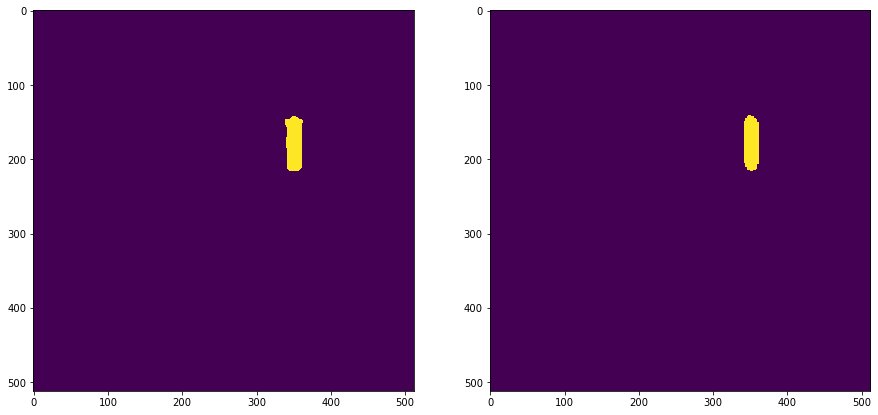

In [200]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(y_val[im_id])
axes[1].imshow(ex)

plt.show()

In [201]:
index=[]
for i in range(200):
    index.append(i)

In [202]:
d = {"img_id": index,
    "rle_mask": ans1}

df = pd.DataFrame(d, index)

In [203]:
df.head()

,img_id,rle_mask
0,0,72540 4 73052 4 73562 10 74074 10 74584 14 750...
1,1,89768 8 90280 8 90790 12 91302 12 91812 16 923...
2,2,49910 2 50422 2 50930 10 51442 10 51952 12 524...
3,3,24304 8 24816 8 25320 20 25832 20 26340 24 268...
4,4,158526 2 159038 2 159544 10 160056 10 160566 1...


In [204]:
filename = 'Unet_Best.csv'
df.to_csv(filename, index=False)

# Анализ метрик:

In [205]:
get_dice(y_val,ans)

0.7698456802157996

In [86]:
train_data =get_test('data', 10)

In [87]:
pred = model.predict(train_data)

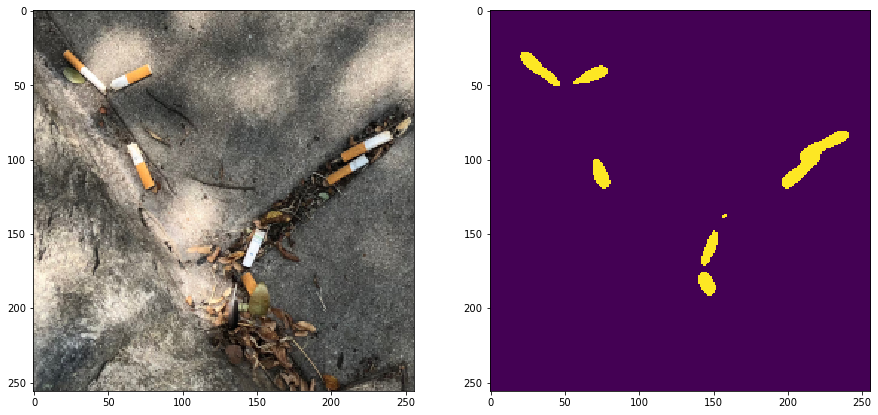

In [178]:
ind_id = 9
val = 0.5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(train_data[ind_id])
axes[1].imshow(pred[ind_id, ..., 0] > val)

plt.show()

In [173]:
a = det_mask(pred[ind_id], val)
a.shape

(512, 512)

In [174]:
A.append(a)

In [175]:
len(A)

10

In [179]:
def save_html1(paths_to_imgs, pred_masks, path_to_save="results/test"):
    
    paths_to_imgs = np.array(paths_to_imgs)
    pred_masks = np.array(pred_masks)

    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    order = np.argsort(paths_to_imgs)
    paths_to_imgs = paths_to_imgs[order]
    pred_masks = pred_masks[order]

    for path_to_img, pred_mask in zip(paths_to_imgs, pred_masks):
        img_id = path_to_img.split("/")[-1].split(".")[0]
        img = np.array(Image.open(path_to_img))[:, :, :3]
        Image.fromarray(img).save(f"{path_to_save}/{img_id}_img.jpg")
        rle_mask = encode_rle(pred_mask)
        decoded_mask = decode_rle(rle_mask)
        Image.fromarray(decoded_mask).save(f"{path_to_save}/{img_id}_pred_mask.png")
        crop_img = img.copy()
        crop_img[pred_mask == 0] = 0
        Image.fromarray(crop_img).save(f"{path_to_save}/{img_id}_crop.png")

In [181]:
paths_to_imgs = sorted(glob("data/real_test/images/*"))
paths_to_imgs

['data/real_test/images\\0000.JPG',
 'data/real_test/images\\0001.JPG',
 'data/real_test/images\\0002.JPG',
 'data/real_test/images\\0003.JPG',
 'data/real_test/images\\0004.JPG',
 'data/real_test/images\\0005.JPG',
 'data/real_test/images\\0006.JPG',
 'data/real_test/images\\0007.JPG',
 'data/real_test/images\\0008.JPG',
 'data/real_test/images\\0009.JPG']

In [183]:
save_html1(paths_to_imgs, A, "results/example1")

# Проверка

In [206]:
pred1 = pd.read_csv("Unet_Best.csv")
a1 = pred1.rle_mask

In [229]:
for i in range(10):
    z = int(random.randint(1,199))
    if (type(a1[196])!=float):
        get_dice(decode_rle(a1[z]),decode_rle(a1[z]))


In [224]:
print(z)

196


In [225]:
type(a1[196])


float